# Python Workshop: Neural Networks in IoT Sensor Data

### Firstly, what are Neural Networks?

Neural networks (NN) are a branch of fundamentally important, yet complex models in machine learning and deep learning. The concept of NNs are greatly inspired by the structure of the human brain and they work very similarly to how our human brains would when trying to understand patterns from data. 

Neural networks are interesting because they are able to perform tasks that typical machine learning models could not. They can learn things like speech/language, process images, and even play games! They are powerful computer tools that we can use to our advantage in analyzing data.

NNs consist of interconnected nodes/artificial neurons, organized into input, output and hidden layers. The output and hidden layers take in the input neurons, apply the corresponding weights, sum them together, and pass the result to the activation function. The activation function is used to determine the output of each neuron based on the weighted sum of the inputs. During training, these input weights are continually adjusted through a process called backpropagation, which iteratively optimizes the NNs performance on the given task and allows for more accurate and robust predictions.

As such, NNs are characteristically proficient at learning complex patterns and correlations from data, making them particularly effective in solving tasks with large datasets, as well.

In summary, a neural network is composed of the following:
1. Input Layer: The first layer, which maps the features from the data into respective input layers (one column = one input layer)
2. Hidden Layer: The layer responsible for computational learning of the NN. Though the input/output layers are determined automatically, we are able to program our hidden layer to meet our problem specifications and optimize our model.
3. Output Layer: The final layer, which is used to predict the target output(s) of the NN. No outgoing connections.
4. Weights & Bias: Weights are used to interpret the significance of an input feature on the target value of the neural network. Biases are used to offset the result of the neural network towards the positive/negative side.
5. Activation Function: The activation function is used to compute the output based on the weighted sum of the inputs.
6. Loss Function: Determines the discrepancy between the predicted output of the NN and the target values in the training data. Iteratively gives feedback to the NN such that changes can be made to the weights to minimize the loss/error.

In [45]:
# Loading in some basic Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import classification_report

### What dataset will we be using?

This dataset describes environmental sensor telemetry data. Sensor telemetry is a valuable tool used by researchers/scientists/engineers to monitor and understand physical environments by collecting and analyzing data in real time.
The data comes from a series of three identical, custom-built, breadboard-based sensor arrays, each connected to a Raspberry Pi microprocessor. Each of these three IoT devices were placed in varied environmental conditions:

                           | device            | environmental conditions                 |
                           |-------------------|------------------------------------------|
                           | 00:0f:00:70:91:0a | stable conditions, cooler and more humid |
                           | 1c:bf:ce:15:ec:4d | highly variable temperature and humidity |
                           | b8:27:eb:bf:9d:51 | stable conditions, warmer and dryer      |

The features generated from the sensors include the temperature, humidity, carbon monoxide (CO), liquid petroleum gas (LPG), smoke, light, and motion of their environment. Each IoT device collected readings from the sensors on a regular interval. The timestamp of each reading is also included in the dataset.

If you would like to read more and access this dataset for yourself, you can find it through this link: https://www.kaggle.com/datasets/garystafford/environmental-sensor-data-132k

In [46]:
# Reading the csv dataset into our Python environment
df = pd.read_csv('iot_telemetry_data.csv', index_col='ts')
df.head() # Only first few rows of data for viewing clarity

,device,co,humidity,light,lpg,motion,smoke,temp
ts,,,,,,,,
1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


Let's see what we can find out about our dataset using ```.info``` and ```.describe```!

In [47]:
# Concise Dataset Summary
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 405184 entries, 1594512094.3859746 to 1595203417.2643125
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   device    405184 non-null  object 
 1   co        405184 non-null  float64
 2   humidity  405184 non-null  float64
 3   light     405184 non-null  bool   
 4   lpg       405184 non-null  float64
 5   motion    405184 non-null  bool   
 6   smoke     405184 non-null  float64
 7   temp      405184 non-null  float64
dtypes: bool(2), float64(5), object(1)
memory usage: 22.4+ MB
None


In our dataset, there are:
- 8 columns and 405184 rows
- 5 float64 columns, 2 boolean  columns and 1 object column
- no missing values from any columns! Each column has 405184 non-null values!

In [48]:
# Descriptive Statistics Analysis
print(df.describe())

                  co       humidity            lpg          smoke  \
count  405184.000000  405184.000000  405184.000000  405184.000000   
mean        0.004639      60.511694       0.007237       0.019264   
std         0.001250      11.366489       0.001444       0.004086   
min         0.001171       1.100000       0.002693       0.006692   
25%         0.003919      51.000000       0.006456       0.017024   
50%         0.004812      54.900000       0.007489       0.019950   
75%         0.005409      74.300003       0.008150       0.021838   
max         0.014420      99.900002       0.016567       0.046590   

                temp  
count  405184.000000  
mean       22.453987  
std         2.698347  
min         0.000000  
25%        19.900000  
50%        22.200000  
75%        23.600000  
max        30.600000  


Provided above are descriptive statistics, summarizing the count, mean, std, min, max, etc. of the numerical columns in our dataset. These statistics can help us identify patterns and detect any outliers in the data that may be overly affecting our neural network's results. 

### Preprocessing for Neural Network

When working with neural networks, there are some requirements of the features in the dataset:
- all data must be numeric
- all data must be scaled

In doing this, we are able to ensure that the neural network algorithm that is able to interpret the data and draw meaningful inferences. 

Let's start by performing a binary encoding on the light and motion columns, such that they display 1s and 0s rather than True and False. 

In [49]:
df[['light','motion']] = df[['light','motion']].astype(int)
df.head()

,device,co,humidity,light,lpg,motion,smoke,temp
ts,,,,,,,,
1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,0,0.007651,0,0.020411,22.700000
1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,0,0.005114,0,0.013275,19.700001
1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,0,0.007673,0,0.020475,22.600000
1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,1,0.007023,0,0.018628,27.000000
1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,0,0.007664,0,0.020448,22.600000


As mentioned in the dataset description, there are three IoT devices (placed in varying environmental conditions) that are generating this sensor data:
- Device name: 00:0f:00:70:91:0a
- Device name: 1c:bf:ce:15:ec:4d	
- Device name: b8:27:eb:bf:9d:51

We can also map these categorical device names to be labelled numerically as device 0, 1, and 2, respectively.

In [50]:
df['device'] = pd.Categorical(df['device'])
df['device'] = df['device'].cat.codes
df.head()

,device,co,humidity,light,lpg,motion,smoke,temp
ts,,,,,,,,
1.594512e+09,2,0.004956,51.000000,0,0.007651,0,0.020411,22.700000
1.594512e+09,0,0.002840,76.000000,0,0.005114,0,0.013275,19.700001
1.594512e+09,2,0.004976,50.900000,0,0.007673,0,0.020475,22.600000
1.594512e+09,1,0.004403,76.800003,1,0.007023,0,0.018628,27.000000
1.594512e+09,2,0.004967,50.900000,0,0.007664,0,0.020448,22.600000


Now that our data has been transformed to be numerical, all that's left for preprocessing is to scale the data. We can do this using the StandardScaler from the sklearn.preprocessing library, which will transform each numerical feature in the data to have a mean of 0 and a standard deviation of 1. Doing so allows our neural network to regularize the features and reduce the effect of potential overfitting or instability.

In [51]:
scaler = StandardScaler()
df[['co','humidity','lpg','smoke','temp']] = scaler.fit_transform(df[['co','humidity','lpg','smoke','temp']])
df.head()

,device,co,humidity,light,lpg,motion,smoke,temp
ts,,,,,,,,
1.594512e+09,2,0.253670,-0.836820,0,0.286471,0,0.280867,0.091172
1.594512e+09,0,-1.438976,1.362631,0,-1.469927,0,-1.465637,-1.020621
1.594512e+09,2,0.269729,-0.845618,0,0.301986,0,0.296495,0.054112
1.594512e+09,1,-0.188651,1.433013,1,-0.148041,0,-0.155499,1.684742
1.594512e+09,2,0.262810,-0.845618,0,0.295303,0,0.289763,0.054112


### Implementing the Neural Network: MLPRegressor

The sklearn library offers base NN modules like the MLP. MLP stands for multi-layer perceptron and is just another name for feedforward neural networks (a type of supervised neural network, note that there are unsupervised neural networks, as well!). Since MLPs are supervised, we are able to use them to perform classification or regression tasks.

For our purposes, let's implement the MLPRegressor() to make predictions about the temperature column from our IoT sensor telemetry dataset.

Let's start by performing a train-test split on the data. We will allocate 80% of the data to training the MLPRegressor and 20% for testing it with "new" data points. 

In [52]:
X = df.drop(columns=['temp'])
y = df['temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The parameters defined in the MLPRegressor are very important to take note of. 

As mentioned before, the input/output layers are predetermined, but we do have some control over our NN's hidden layer. The ```hidden_layer_sizes``` parameter controls how many hidden layers we wish to create within our NN. Increasing the complexity of the hidden layers may give better accuracy results, but will also lead to significantly greater runtimes. Make sure to choose an argument that best matches the problem at hand. 

Also, using the ```max_iter``` and ```learning_rate_init``` parameters, we are able to solve any ```ConvergenceWarning``` errors, which means our NN was not able to find an optimal solution within the given step limit. ```max_iter``` is quite self-explanatory and it limits the amount of iterations that are allowed for the NN to converge. We could also adjust the ```learning_rate_init``` parameter which changes the step-size of the weights in each iteration of the training process. Setting this argument too large, however, may lead to the model jumping over the optimal value for an input neuron's weight. We need to find a balance where our NN is able to learn quick enough to converge within the given limit of iterations, but not that it misses the best input weight configuration.

| Parameter | Definition |
|:--------:|:--------:|
|  hidden_layer_sizes  |  Defines hidden layer with neurons specified as parameter   |
|  max_iter   |  Max steps allowed for the neural network to converge  |
|  learning_rate_init   |  Controls the step-size in updating the feature weights   |

This is how we can define a basic MLPRegressor model to start:

In [53]:
NNR = MLPRegressor(
    hidden_layer_sizes=(100), 
    max_iter=200,
    learning_rate_init=0.003,
    random_state=42
    )

In [54]:
NNR.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=100, learning_rate_init=0.003, random_state=42)

Using the ```.score``` method, we can evaluate the performance of our MLPRegressor model. By default, this will calculate the R-squared score, a measure of the correlation between the input features and the target (temperature column, in our case).

In [55]:
NNR.score(X_test, y_test)

0.9109385193067144

Using our parameters, we were able to obtain a MLPRegressor model with a 91.1% R-squared score! This is generally a very high accuracy rate for a simple neural network model such as this one, which may suggest that this data might have been artificially simulated or generated. Regardless, I hope this example was able to showcase how a neural network can be implemented to make meaningful predictions from any type of IoT data.

As an exercise, try playing around with some of the MLPRegressor model's parameters and see how that affects the R-squared score of the model.

### Comparing R-squared with other Regressor Models

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

regressors = [
    ("Linear Regression", LinearRegression()),
    ("K-Neighbors Regression", KNeighborsRegressor()),
    ("Decision Tree Regression", DecisionTreeRegressor())
]

for name, model in regressors:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"{name}: R-squared score = {score:.4f}")

Linear Regression: R-squared score = 0.7864
K-Neighbors Regression: R-squared score = 0.9312
Decision Tree Regression: R-squared score = 0.9260


We can see that the MLPRegressor's prediction of the temperature column yields significantly greater results than the LinearRegression(), as expected! However, even with tuned parameters, our simple MLPRegressor model's R-squared score falls just short of the K-Neighbors and Decision Tree Regressors. This may be the case because the variables in our dataset are all quite simply correlated, while the NN really exceeds in determining more complex patterns.

### Introspecting our Neural Network Model

#### How many input neurons are in our Neural Network?

Recall that the number of input neurons directly corresponds to the number of features in our dataset.

In [57]:
print(X.shape)

(405184, 7)


#### How many output neurons are in our Neural Network?

In [58]:
NNR.n_outputs_

1

Since we are only attempting to predict the temperature column as a single continuous value, there is only one output neuron in our neural network.

#### How many iterations did it take for our neural network to make this prediction about the target column?

In [59]:
num_iters = NNR.n_iter_
num_iters

44

Feel free to go back to the MLPRegressor model we defined above and change the ```max_iter``` parameter to be more suitable!

#### Understanding the Weights in our Neural Network

In [60]:
weights = NNR.coefs_
weights

[array([[-2.94022663e-001,  2.27255855e-001,  1.97705814e-002,
          5.93242229e-003, -6.14524374e-001, -6.39652835e-001,
         -1.15169207e+000, -1.49804871e-315, -2.43873672e-001,
          8.64703957e-002, -1.41725204e+000, -1.49275480e+000,
          9.17030515e-002, -4.59192806e-001, -3.75886449e-001,
         -4.14266927e-001,  1.02608460e-315, -1.20874408e-315,
         -5.31696458e-001,  1.47161770e-315, -1.19910928e-315,
         -3.75669810e-316, -8.38295519e-001, -1.57126634e-002,
          1.45836168e-315,  9.74714203e-316, -9.41234624e-001,
          3.09341462e-002, -4.70632380e-001, -4.03444821e-001,
          2.42032823e-003,  1.38588001e-127, -6.46925637e-001,
         -4.13111426e-002,  4.71163765e-001, -1.13502590e-315,
          1.00108406e-316, -1.26872413e+000,  4.35407346e-316,
         -8.79378451e-001, -2.47183217e-001,  3.16989900e-001,
         -4.80528845e-001, -1.29480997e-315, -2.31647477e+000,
          9.69493200e-002, -2.79273099e-001, -4.2182045

In [66]:
len(weights)

2

As you can see, there are two main arrays shown. ```weights[0]``` is responsible for the weights from the input layer to hidden layer, and ```weights[1]``` is for the hidden layer to the output layer.

The number of sub-arrays within ```weights[0]``` represents the number of input neurons, and the number of elements within each sub-array represents the number of hidden neurons. We defined our MLPRegressor to have 7 features and a hidden_layer_sizes of 100. Does this check out?

Also in taking a look at ```weights[1]```, we see that we have 100 sub-arrays with 1 element each. Since we have our hidden_layer_sizes to be 100, and we only have one output neuron (temperature column), this matches up!

#### Loss Curve for MLPRegressor

The loss curve is a graphical respresentation of the neural network's errors over the course of its training period. At each iteration of the model, the loss function calculates the differences between the NN's predicted output and the actual target value. As the neural network model (MLPRegressor in our case) learns the best weights for each of the features, we should see the loss value decrease until the model reaches convergence. 

In [61]:
loss_curve = NNR.loss_curve_
print(loss_curve)

[0.06938455277772503, 0.05556011389101311, 0.05316916274543732, 0.05168287559982579, 0.04963829231773575, 0.048757676813733664, 0.047539503275319604, 0.04696990920124732, 0.04649686356663884, 0.04611270615750879, 0.045855286033228325, 0.04556472026991299, 0.04539778036229684, 0.04493249869294282, 0.04499761179857567, 0.04482849645206061, 0.04474123229607674, 0.044480451914458, 0.044639751847872264, 0.04434228301187969, 0.04431867609180059, 0.044188959004264845, 0.044043039320498, 0.04404555036236652, 0.04398897664796545, 0.04400735488372841, 0.043815755102754386, 0.04375086312997488, 0.043758065984060075, 0.043618056367726976, 0.04358420983844569, 0.043644478010988, 0.043406725971517617, 0.043510110887484264, 0.043355618225656985, 0.043624243985468755, 0.04327960165620418, 0.04339381066369281, 0.04330452907832872, 0.043249761410645626, 0.04317867779043174, 0.043306923060669585, 0.04322267540615008, 0.043232207911955506]


In [62]:
# Checking that loss function calculated at every iteration
print(len(loss_curve) == num_iters)

True


<Axes: >

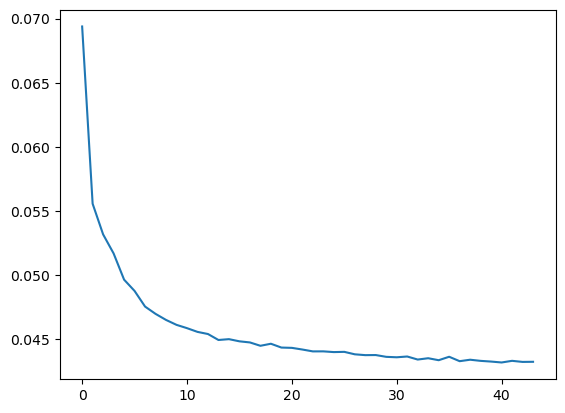

In [63]:
# Plotting loss curve
pd.Series(loss_curve).plot.line()

<Axes: >

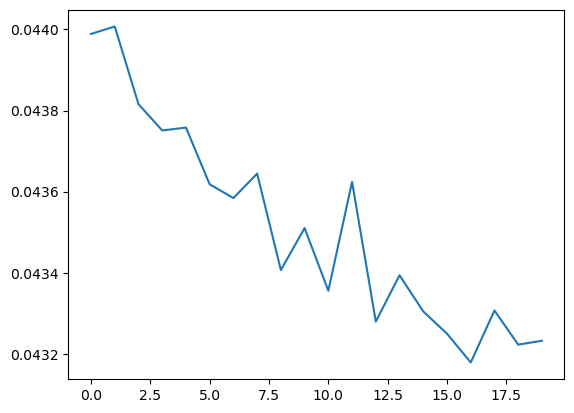

In [64]:
# Plotting last few iterations only
pd.Series(loss_curve[-20:]).plot.line()

#### How exactly does the NN determine a convergence point?

The two key parameters that determine the convergence of a NN are: ```tol``` and ```n_iter_no_change```.

In [65]:
print(NNR.tol)
print(NNR.n_iter_no_change)

0.0001
10


We can see from the plots above that the loss value is continually improving as the MLPRegressor is trained. Basically, if the loss is not improved by the amount ```tol``` for a ```n_iter_no_change```  number of iterations, then the NN model is considered to have reached convergence and the training process concludes.

### Your turn!

This time, on your own, try implementing a basic MLPRegressor to predict the ```humidity``` column from our IoT sensor telemetry dataset. This process will follow closely along with the example we showcased using the temperature column, so feel free to refer above for hints and clarification!

Start by:
1. Performing a train-test split on the data
2. Creating a MLPRegressor model and fitting training data
3. Testing and getting R-squared score
4. Introspecting + Viewing Loss Curve